<a href="https://colab.research.google.com/github/park-geun-hyeong/Dacon/blob/main/Computer_Vision1/Computer_Vision1_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library import and Confirm Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import cv2
from PIL import Image

import os 
import time
import glob 
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision

In [2]:
path = '/content/drive/MyDrive/Dacon/computer_vision1/'

train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [3]:
train

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,1,2,1,3,3,4,4,3,4,1,0,4,4,4,1,1,1,2,3,4,1,2,3,3,2,3,1,3,4,0,...,2,4,1,1,1,1,2,3,1,2,0,2,4,1,0,3,4,4,0,1,3,3,3,3,2,0,3,3,3,2,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,1,4,2,0,3,3,2,2,1,2,3,2,2,4,1,0,4,1,0,2,0,3,0,2,3,3,3,4,0,4,...,0,1,1,1,1,3,0,4,2,0,4,3,1,4,0,1,0,0,3,3,0,0,1,3,3,1,2,0,3,2,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,4,3,4,0,1,3,4,1,0,2,2,0,0,3,3,2,0,4,3,2,3,4,3,1,1,4,4,4,1,1,...,3,2,4,3,2,1,1,0,4,0,4,4,1,3,3,1,3,4,1,0,2,4,1,2,4,4,4,3,4,2,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,3,0,1,4,0,0,0,2,3,1,1,1,0,2,4,1,0,3,0,1,2,4,1,4,3,1,4,4,4,0,...,0,0,2,0,2,3,2,0,3,0,1,0,1,0,1,2,3,2,1,1,0,0,3,1,4,1,1,2,1,3,2,3,1,1,0,4,1,4,3,1


In [4]:
test

,id,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,1,0,0,2,4,3,2,0,1,3,1,1,0,2,0,4,4,2,3,0,2,2,2,2,1,3,2,2,4,1,...,1,4,4,2,1,3,4,2,3,2,4,2,3,1,1,3,2,4,3,1,2,1,3,0,4,2,2,1,1,4,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,4,3,2,3,3,2,2,0,0,0,2,4,3,0,2,0,2,4,2,3,3,1,4,2,2,3,2,2,2,0,...,1,1,0,2,1,4,4,4,0,1,2,4,4,4,1,2,4,2,1,4,1,0,1,0,4,2,0,0,3,4,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,4,4,1,0,0,1,2,1,2,2,0,3,0,4,0,2,3,3,4,1,2,0,1,2,4,3,1,3,3,1,...,1,3,3,2,1,3,0,3,2,3,2,4,2,0,4,2,2,2,1,1,0,3,0,2,1,4,3,2,3,4,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,1,2,2,3,1,2,3,4,1,3,1,0,3,3,1,2,4,3,4,1,0,0,1,1,0,4,1,3,2,2,...,0,4,0,2,4,2,1,3,2,0,1,3,0,4,1,4,2,3,3,2,2,1,4,2,0,3,0,3,2,4,2,0,0,4,3,3,3,4,4,2


In [5]:
submission = pd.read_csv(path+'submission.csv')
submission

,id,digit
0,2049,0
1,2050,0
2,2051,0
3,2052,0
4,2053,0
...,...,...
20475,22524,0
20476,22525,0
20477,22526,0
20478,22527,0


In [6]:
train_img = train.iloc[:,3:].values.reshape(-1,28,28).astype(np.uint8)
test_img = test.iloc[:,2:].values.reshape(-1,28,28).astype(np.uint8)

train_digits = train.iloc[:,1].values
train_letters = train.iloc[:,2].values

In [7]:
train_img.shape,test_img.shape

((2048, 28, 28), (20480, 28, 28))

In [ ]:
example = np.random.randint(train_img.shape[0])

plt.figure(figsize=(8,8))
plt.imshow(train_img[example], cmap='gray')
plt.title("train_Example: {}, digits: {}, letters: {}".format(example, train_digits[example], train_letters[example]))
plt.show()

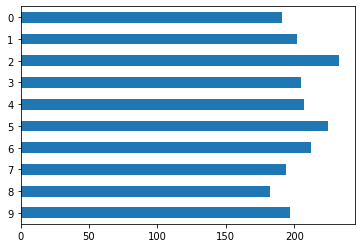

In [9]:
train['digit'].value_counts().sort_index(ascending=False).plot.barh()

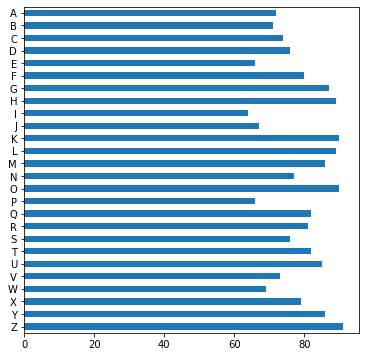

In [10]:
plt.figure(figsize=(6,6))
train['letter'].value_counts().sort_index(ascending=False).plot.barh()

In [11]:
train['letter'] = train['letter'].replace({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25})
train_target = train.iloc[:,1:3].values
train_target


array([[ 5, 11],
       [ 0,  1],
       [ 4, 11],
       ...,
       [ 9,  0],
       [ 0, 25],
       [ 5, 25]])

## Split Validiation_Data

In [ ]:
!pip install iterative-stratification

In [13]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

ms = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
train['fold'] = -1

for i ,(trn_idx, val_idx) in enumerate(ms.split(train_img, train_target)):
    train.loc[val_idx, 'fold'] = i

In [15]:
trn_fold = [0,1,2,3]
val_fold = [4]

train_idx = train.loc[train.fold.isin(trn_fold)].index
val_idx = train.loc[train.fold.isin(val_fold)].index  

In [16]:
len(train_idx), len(val_idx)

(1640, 408)

##Dataset, DataLoader

In [17]:
from torch.utils.data import Dataset, DataLoader

In [228]:
class ImageData(Dataset):
    def __init__(self,csv,transform):
        self.csv = csv.reset_index()
        self.transform = transform
        self.img_ids = self.csv['id'].values

    def __len__(self):
        return len(self.csv)

    def __getitem__(self,index: int):
        img_id = self.img_ids[index]

        img_array = np.array(self.csv.iloc[index][3:787])

        img = img_array.reshape(28,28).astype(np.uint8)
        img = img[:,:,np.newaxis]
        img = np.repeat(img,3,2)

        if self.transform is not None:
            img = self.transform(image=img)['image']
        
        label = self.csv.iloc[index].digit
                               
        return img, np.array(label)

In [241]:
import albumentations as A
from albumentations.pytorch import ToTensor

train_transform = A.Compose([
                             
                             A.HorizontalFlip(p=0.3),
                             A.Rotate(20,p=0.3),
                             ToTensor(),

])

val_transform = A.Compose([
                           ToTensor()
])

In [242]:
train_dataset = ImageData(csv = train.loc[trn_idx], transform = train_transform)
val_dataset = ImageData(csv = train.loc[val_idx], transform = val_transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle=False, num_workers=2) 

In [243]:
for inputs, target in train_loader:
    break

## Model 

In [ ]:
! pip install pretrainedmodels

In [231]:
import pretrainedmodels

model_name = 'resnet34'
model = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

In [232]:
in_features = model.last_linear.in_features

In [233]:
model.last_linear = nn.Linear(in_features, 10, bias=False)

In [236]:

import torch.optim as optim
from sklearn.metrics import accuracy_score

In [237]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5) ## 평가 metric의 변화가 없을 때 rl를 줄여주는 함수(mode=metric의 상태, factor=lr를 줄이는 배수, patience=최대 몇번의 실패를 참을것인지-epochs)

In [165]:
from tqdm import tqdm_notebook

## Train

In [263]:
model = model.cuda()
os.chdir(path)
best_score = -1

for epoch in tqdm_notebook(range(30)):
    train_loss=[]
    model.train()

    for inputs, targets in train_loader:

        inputs = inputs.cuda()
        targets = targets.cuda()

        optimizer.zero_grad()
        logits = model(inputs)
        
        loss = loss_fn(logits,targets)

        loss.backward()
        optimizer.step()

        train_loss.append(np.round(loss.item(),4))

    val_true=[]
    val_pred=[]
    val_loss=[]

    model.eval()

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.cuda()
            targets = targets.cuda()

            optimizer.zero_grad()

            logits = model(inputs)

            loss = loss_fn(logits, targets)

            val_loss.append(np.round(loss.item(),4))

            val_true.append(targets.cpu().data.numpy())
            val_pred.append(logits.cpu().argmax(dim=1).data.numpy())


    val_true = np.concatenate(val_true)
    val_pred = np.concatenate(val_pred)

    val_loss = np.mean(val_loss)
    train_loss = np.mean(train_loss)

    final_score = accuracy_score(val_true, val_pred)
    
    print(f"epochs: {epoch+1}, train_loss:{train_loss}, val_loss:{val_loss}, score:{final_score:.4f}")


    if final_score > best_score:
        final_score = best_score

        state_dict = model.cpu().state_dict()
        model = model.cuda()

        torch.save(state_dict, 'model.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


epochs: 1, train_loss:1.746101923076923, val_loss:1.6550576923076923, score:0.4338
epochs: 2, train_loss:1.5481326923076923, val_loss:1.6008384615384612, score:0.4657
epochs: 3, train_loss:1.3643807692307692, val_loss:1.3124615384615386, score:0.5368
epochs: 4, train_loss:1.213251923076923, val_loss:1.3394307692307688, score:0.5466
epochs: 5, train_loss:1.0950788461538463, val_loss:1.4470923076923075, score:0.5025
epochs: 6, train_loss:1.0418173076923076, val_loss:1.3505115384615383, score:0.5686
epochs: 7, train_loss:1.037203846153846, val_loss:1.4603461538461535, score:0.5637
epochs: 8, train_loss:0.9507442307692304, val_loss:1.2426923076923078, score:0.6127
epochs: 9, train_loss:0.8619384615384615, val_loss:1.4783615384615383, score:0.5882
epochs: 10, train_loss:0.8637826923076923, val_loss:1.0124192307692306, score:0.6520
epochs: 11, train_loss:0.7601423076923078, val_loss:1.1363884615384614, score:0.6373
epochs: 12, train_loss:0.7029846153846153, val_loss:1.0643923076923074, score

In [264]:
model.load_state_dict(torch.load('model.pt')) ## save best weight

<All keys matched successfully>

## Test Dataset, Test DataLoader

In [265]:
class TestData(Dataset):
    def __init__(self,csv,transform):
        self.csv = csv
        self.img_ids = self.csv.id.values
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self,index: int):
        img_id = self.img_ids[index]

        img_array = np.array(self.csv.iloc[index,2:])

        img = img_array.reshape(28,28).astype(np.uint8)
        img = img[:,:,np.newaxis]
        img = np.repeat(img,3,2)

        if self.transform is not None:
            img = self.transform(image=img)['image']
        
                             
        return img 

In [266]:
test_transform = A.Compose([
                            ToTensor()
])

In [267]:
test_dataset = TestData(csv = test, transform = test_transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False,num_workers=2)

In [268]:
for inputs in test_loader:
    break

In [ ]:
model.eval()
model.cuda()

##Predict 

In [270]:
y_pred = []

for inputs in test_loader:
    with torch.no_grad():
        inputs = inputs.cuda()
        output = model(inputs)

        digit = output[:,:10] 
        y_pred.append(np.argmax(np.array(digit.cpu().data), axis=1))



In [271]:
sample = np.concatenate(y_pred, axis=0)

In [272]:
submission['digit'] = sample 

In [273]:
submission

,id,digit
0,2049,6
1,2050,8
2,2051,8
3,2052,0
4,2053,3
...,...,...
20475,22524,4
20476,22525,1
20477,22526,0
20478,22527,1


In [275]:
os.chdir('/content')
submission.to_csv("submission_pytorch2.csv",index=False)